In [1]:
from geom2vec.data import Preprocessing
import torch

folder_path = '/project/dinner/zpengmei/geom2vec/results/chignolin_stride10'
preprocess = Preprocessing(torch_or_numpy='torch')
raw_dataset = preprocess.load_dataset(data_path=folder_path,mmap_mode='r')
# we concatenate the data of the same trajectory
dataset = torch.cat(raw_dataset).sum(1)
del raw_dataset

/project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 486.33it/s]


In [2]:
# read the data
import scipy
import numpy as np

data = np.load("/project/dinner/zpengmei/geom2vec/tutorial/data/chignolin/chignolin.npz")
ca_rmsds = data['ca_rmsds']
qtots = data['qtots']
end_end_dists = data['end_end_dists']
ca_dists = data['ca_dists']
chi1s = data['chi1s']
trp_psi = data['trp_psi']
tics = data['tics']

assert len(ca_rmsds) == len(qtots) == len(end_end_dists) == len(ca_dists) == len(chi1s) == len(trp_psi) == len(tics) == len(dataset)


In [3]:
# define the state
dtype = torch.float32

ca_rmsd_arr = ca_rmsds * 10
smoothed_qtots = scipy.signal.convolve(qtots, np.ones(50) / 50, mode="same")
end_end_arr = end_end_dists * 10
folded = ((((smoothed_qtots - 0.5)**2 / 0.1**2) + ((ca_rmsd_arr - 1)**2)) < 1) & (chi1s[:, 5] > 0) & (trp_psi > 0)
unfolded = (smoothed_qtots < 0.1) & (ca_rmsd_arr > 3) & (end_end_arr > 10) & (tics[:, 1] < -1)

label_traj = np.zeros(len(folded))
label_traj[folded] = 2
label_traj[unfolded] = 3
transitions = np.nonzero(np.diff(label_traj))[0]
print(label_traj[:20])
print(transitions[:20])
print(np.diff(label_traj)[transitions][:20])
diff_transitions = np.diff(label_traj)[transitions]
# folded, D, unfolded gives -2, 3, sum is 1
print(np.count_nonzero((diff_transitions[:-1] == -2) & (diff_transitions[1:] == 3)))
# unfolded, D, folded gives -3, 2, sum is -1
print(np.count_nonzero((diff_transitions[1:] + diff_transitions[:-1]) == -1))

guess_f = torch.tensor(folded, dtype=dtype).unsqueeze(-1)
in_d = torch.tensor(~(folded | unfolded), dtype=dtype).unsqueeze(-1)
in_a = torch.tensor(unfolded, dtype=bool).unsqueeze(-1)
in_b = torch.tensor(folded, dtype=bool).unsqueeze(-1)
print(in_d.shape)

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[ 24  25  33  34  55  56  64  65  67  68  87 120 138 145 160 198 206 207
 211 222]
[-3.  3. -3.  3. -3.  3. -3.  3. -3.  3. -3.  2. -2.  2. -2.  2. -2.  2.
 -2.  2.]
33
34
torch.Size([53475, 1])


/scratch/local/jobs/20654661/ipykernel_2803204/1063902503.py:5: RuntimeWarning: divide by zero encountered in log
  pc = ax.pcolormesh(xe, ye, (-np.log(num) - np.nanmin(-np.log(num))).T, cmap='viridis', vmin=0)


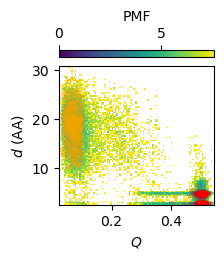

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(2, 2.25))
num, xe, ye = np.histogram2d(smoothed_qtots, end_end_dists * 10, bins=100)
pc = ax.pcolormesh(xe, ye, (-np.log(num) - np.nanmin(-np.log(num))).T, cmap='viridis', vmin=0)
ax.plot(smoothed_qtots[unfolded][::10], end_end_dists[unfolded][::10] * 10, '.', color='orange', alpha=0.1)
ax.plot(smoothed_qtots[folded][::100], end_end_dists[folded][::100] * 10, '.', color='red', alpha=0.1)
ax.set_xlabel("$Q$")
ax.set_ylabel(r"$d\ (\text{\AA})$")
fig.colorbar(pc, ax=ax, label="PMF", location='top')

In [5]:
dataset[0].shape

torch.Size([4, 128])

In [6]:
# create the dataset with B.C.
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

bc_dataset = preprocess.create_boundary_dataset(
    dataset, in_a, in_b
)

train_data, val_data = random_split(bc_dataset, [len(bc_dataset) - 5000, 5000])
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1000, shuffle=False)

In [7]:
for data, ina, inb in train_loader:
    print(data.shape, ina.shape, inb.shape)
    break

torch.Size([1000, 4, 128]) torch.Size([1000, 1]) torch.Size([1000, 1])


In [8]:
bc_dataset[0][0].shape

torch.Size([4, 128])

In [9]:
from geom2vec.downstream_models import VarComm
from geom2vec import Lobe

# define the model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = Lobe(
    hidden_channels=128,
    intermediate_channels=128,
    output_channels=1,
    num_layers=3,
    batch_norm=False,
    vector_feature=True,
    mlp_dropout=0.1,
    mlp_out_activation=torch.nn.Sigmoid(),
    device=device,
)

model = VarComm(
    lobe = net,
    optimizer = 'adam',
    learning_rate = 1e-4,
    epsilon = 1e-1,
    k=10,
)

model.fit(train_loader=train_loader, n_epochs=5,val_loader=val_loader)


/project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


VarComm(
  (_lobe): lobe(
    (dropout): Dropout(p=0.1, inplace=False)
    (input_projection): EquivariantScalar(
      (output_network): ModuleList(
        (0): GatedEquivariantBlock(
          (vec1_proj): Linear(in_features=128, out_features=128, bias=False)
          (vec2_proj): Linear(in_features=128, out_features=128, bias=False)
          (update_net): Sequential(
            (0): Linear(in_features=256, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=256, bias=True)
          )
          (act): SiLU()
        )
        (1): GatedEquivariantBlock(
          (vec1_proj): Linear(in_features=128, out_features=128, bias=False)
          (vec2_proj): Linear(in_features=128, out_features=128, bias=False)
          (update_net): Sequential(
            (0): Linear(in_features=256, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=256, bias=True)
          )
        )
  

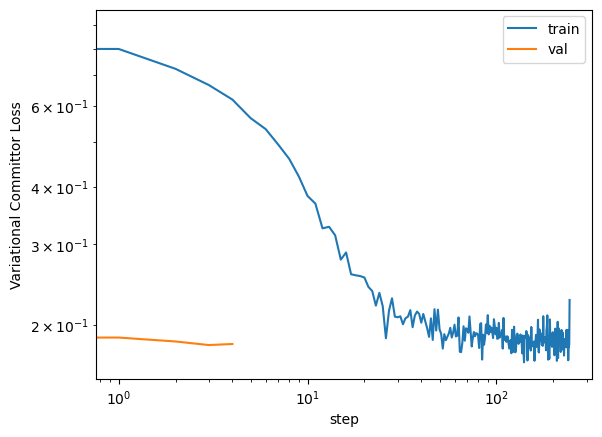

In [10]:
train_score = model.training_scores
val_score = model.validation_scores

import matplotlib.pyplot as plt

plt.loglog(train_score, label='train')
plt.loglog(val_score, label='val')
plt.xlabel('step')
plt.ylabel('Variational Committor Loss')
plt.legend()
plt.show()

In [11]:
comm = model.transform(bc_dataset,batch_size=1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 487.98it/s]
